In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from keras.models import Model
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2  # pip3 install opencv-python

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# IMAGES_PATH = "data/GS_pokemon_images/"
IMAGES_PATH = "data/pokemon_images/"
# NUM_CHANNELS = 1
NUM_CHANNELS = 3  # RGB
IMAGE_SIZE = 96
INPUT_DIM = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
FIRST_INTERMEDIATE_DIM = 1024
SECOND_INTERMEDIATE_DIM = 256
LATENT_DIM = 2  # tiene que ser 2 para poder ser graficado en un plot
EPOCHS = 100

def sampling(args: tuple):
    z_mean, z_log_var = args
    print(z_mean)
    print(z_log_var)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon  # h(z)


def read_pokemon_images():
    X = []
    y = []
    for image_file_name in os.listdir(IMAGES_PATH):
        image = keras.preprocessing.image.load_img(IMAGES_PATH + image_file_name, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = keras.preprocessing.image.img_to_array(image)
        image = image / 255.0
        X.append(image)
        # get id in file name
        image_id = image_file_name.split(".")[0].split("/")[-1]
        y.append(int(image_id))

    X = np.array(X)
    # reshape so its a 4d array
    X = X.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    X = X.reshape((len(X), np.prod(X.shape[1:])))

    # example of image
    # plt.figure(figsize=(10, 10))
    # plt.imshow(images[0][:, :, 0])
    # plt.show()

    return X, y


Tensor("mean_1/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("log-variance_1/BiasAdd:0", shape=(None, 2), dtype=float32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 27648)]      0           []                               
                                                                                                  
 encoding2 (Dense)              (None, 256)          7078144     ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding2[0][0]']              
                                                                                                  
 log-variance (Dense)           (None, 2)            514         

2022-11-23 22:28:10.669107: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/RMSprop/decoder_h_1/kernel/rms/Assign' id:1392 op device:{requested: '', assigned: ''} def:{{{node training_2/RMSprop/decoder_h_1/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/RMSprop/decoder_h_1/kernel/rms, training_2/RMSprop/decoder_h_1/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


151/151 [==============================] - 3s 22ms/sample - loss: 67107277912.2774
Epoch 2/100
151/151 [==============================] - 2s 16ms/sample - loss: 7725.9608
Epoch 3/100
151/151 [==============================] - 3s 17ms/sample - loss: 6739.2074
Epoch 4/100
151/151 [==============================] - 3s 17ms/sample - loss: 6242.0194
Epoch 5/100
151/151 [==============================] - 3s 17ms/sample - loss: 5894.1163
Epoch 6/100
151/151 [==============================] - 3s 17ms/sample - loss: 5636.0290
Epoch 7/100
151/151 [==============================] - 3s 17ms/sample - loss: 5432.5365
Epoch 8/100
151/151 [==============================] - 3s 17ms/sample - loss: 5301.0562
Epoch 9/100
151/151 [==============================] - 2s 16ms/sample - loss: 5189.2443
Epoch 10/100
151/151 [==============================] - 2s 16ms/sample - loss: 5128.1355
Epoch 11/100
151/151 [==============================] - 2s 16ms/sample - loss: 5079.3556
Epoch 12/100
151/151 [=============

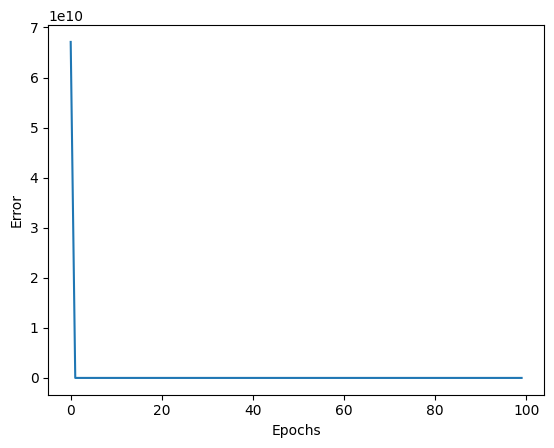

2022-11-23 22:32:27.475283: W tensorflow/c/c_api.cc:291] Operation '{name:'mean_1/BiasAdd' id:891 op device:{requested: '', assigned: ''} def:{{{node mean_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](mean_1/MatMul, mean_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


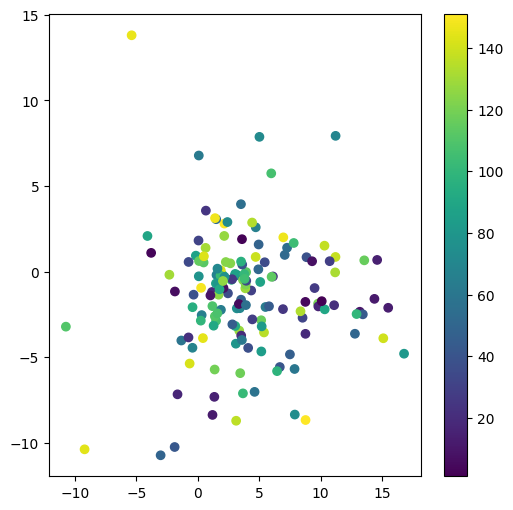

In [22]:

# load input
X, y = read_pokemon_images()
X_train = X_test = X
y_train = y_test = y

# --------------------------- encoder ---------------------------
x = Input(shape=(INPUT_DIM,), name="input")
# intermediate layer
h = Dense(FIRST_INTERMEDIATE_DIM, activation='relu', name="encoding")(x)
h = Dense(SECOND_INTERMEDIATE_DIM, activation='relu', name="encoding2")(x)
# defining the mean of the latent space
z_mean = Dense(LATENT_DIM, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(LATENT_DIM, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(LATENT_DIM,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

# --------------------------- decoder ---------------------------
input_decoder = Input(shape=(LATENT_DIM,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(SECOND_INTERMEDIATE_DIM, activation='relu', name="decoder_h2")(input_decoder)
decoder_h = Dense(FIRST_INTERMEDIATE_DIM, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(INPUT_DIM, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

# --------------------------- VAE ---------------------------
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()


def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
    # Aca se computa la cross entropy entre los "labels" x que son los valores 0/1 de los pixeles, y lo que salió al final del Decoder.
    xent_loss = INPUT_DIM * binary_crossentropy(x, x_decoded_mean)  # x-^X
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss


vae.compile(loss=vae_loss, optimizer='rmsprop')
vae.summary()

history = vae.fit(X_train, X_train, epochs=EPOCHS, batch_size=20, shuffle=True)
#plot error vs epoch
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.show()

# Para ver el rango de latent space?
x_test_encoded = encoder.predict(X_test)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show(block=True)


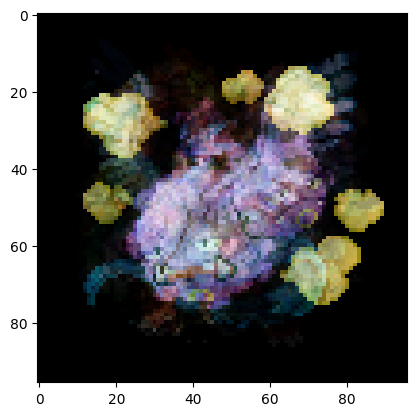

In [30]:
sample_vector = np.array([[-10.4,-3]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
plt.imshow(decoded_example_reshaped)

In [44]:
print(os.getcwd())
from .ui.interface import Interface

interface = Interface(lambda x: decoder.predict(x)[0], IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS, min(x_test_encoded[:, 0]),
            min(x_test_encoded[:, 1]),max(x_test_encoded[:, 0]),max(x_test_encoded[:, 1]))
interface.show_interface()


/home/manurodriguez/Desktop/ITBA/sia/sia-repo/TP3


ModuleNotFoundError: No module named 'TP3'